# Validation

In [122]:
# general
import copy
import os
from collections import Counter, defaultdict
import cv2
import numpy as np

# custom code
import torch
from detectron2.engine import DefaultPredictor
from zebrafish.configs import load_config
from zebrafish.dataset import get_dataset, register_datasets, load_all_image_in_dataset
from zebrafish.evaluation import coco_evaluation, coco_evaluation_all_model
from zebrafish.model import predict
from zebrafish.visualization import plot_prediction, plot_train_vs_validation_loss, plot_segementation, plot_segementation_vs_real, plot_all_model_validation_loss
from zebrafish.utils import is_in_main_dir

#detectron
from detectron2.utils.logger import setup_logger
from detectron2.structures.boxes import matched_boxlist_iou


setup_logger()

if "notebooks" in os.getcwd() and "colab" in os.getcwd():
    os.chdir("..")
    os.chdir("..")

assert is_in_main_dir(), "The notebook expectes you to be in the main directory"

register_datasets("dataset")

## Restore model

In [123]:
model_name = "2020_06_05_17_28_10"
threshold = 0.9
n_images = 1
path_to_model = "output/" + model_name


cfg = load_config(path_to_model)

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold
predictor = DefaultPredictor(cfg)

In [124]:
from detectron2.data import detection_utils as utils

def mapper(dataset_dict):
	# Implement a mapper, similar to the default DatasetMapper, but with your own customizations
	dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
	image = utils.read_image(dataset_dict["file_name"], format="BGR")

	dataset_dict["image"] = image

	instances = utils.annotations_to_instances(dataset_dict["annotations"], image.shape[:2])
	dataset_dict["instances"] = utils.filter_empty_instances(instances)

	return dataset_dict

In [125]:
dataset_name = "test"

dataset = get_dataset(dataset_name, cfg)
item = mapper(dataset[0])
prediction = predictor(item["image"])

{'file_name': 'dataset/training disordered_Snapshot_20190312_2885.jpg',
 'image_id': 0,
 'height': 1623,
 'width': 1629,
 'annotations': [{'bbox': [549, 357, 1104, 726],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'segmentation': [[1005.5,
     393.5,
     907.5,
     475.5,
     821.5,
     506.5,
     635.5,
     607.5,
     549.5,
     637.5,
     576.5,
     714.5,
     629.5,
     726.5,
     788.5,
     653.5,
     974.5,
     581.5,
     1067.5,
     495.5,
     1104.5,
     389.5,
     1024.5,
     357.5]],
   'category_id': 0,
   'iscrowd': 0},
  {'bbox': [955, 538, 1191, 1206],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'segmentation': [[1031.5,
     549.5,
     976.5,
     544.5,
     955.5,
     603.5,
     957.5,
     661.5,
     990.5,
     707.5,
     1007.5,
     812.5,
     1093.5,
     1123.5,
     1117.5,
     1206.5,
     1191.5,
     1169.5,
     1190.5,
     1106.5,
     1158.5,
     966.5,
     1128.5,
     771.5,
     1069.5,
     614.5,
     1039.5,
     538.5,
  

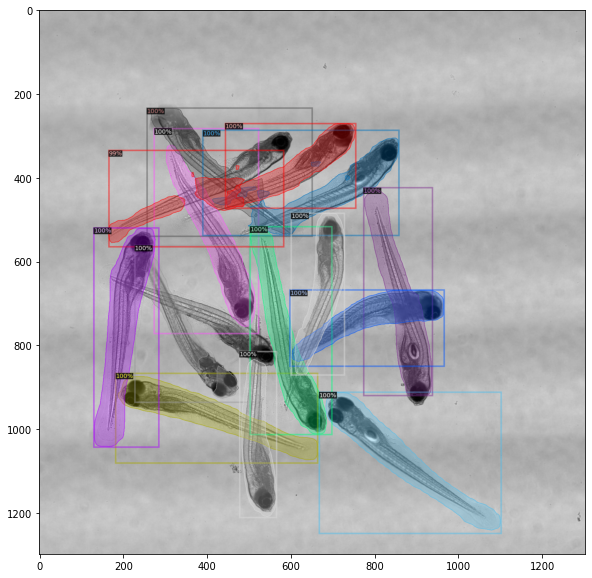

In [155]:
plot_prediction(item["image"], prediction, cfg)

In [127]:
idx = 0
pred_box = prediction["instances"].pred_boxes[idx]
pred_class = prediction["instances"].pred_classes[idx]
score = prediction["instances"].scores[idx]

assert score > 0.5

item["instances"].gt_boxes.tensor = item["instances"].gt_boxes.tensor.cuda()

detections = []
for i in range(len(item["instances"].gt_boxes)):
    gt_box = item["instances"].gt_boxes[i]
    gt_class = item["instances"].gt_classes[i]
    iou = matched_boxlist_iou(gt_box, pred_box)[0].cpu().numpy()
    if iou > 0.5:
        detections.append(i)

detections

[9]

In [152]:
threshold_score = 0.5
IoU_threshold = 0.5
gt_instances = item["instances"]
pred_instances = prediction["instances"]

n_gt_instances = len(gt_instances)
n_pred_instances = len(pred_instances)

gt_to_match = dict()
matches = set()
matched_gts = set()
matched_predictions = set()

matches_per_gt = dict()
matches_per_pred = dict()


for i in range(n_gt_instances):
    gt_instance = gt_instances[i]
    gt_box = gt_instance.gt_boxes
    for j in range(n_pred_instances):
        pred_instance = pred_instances[j]
        pred_box = pred_instance.pred_boxes
        pred_score = pred_instance.scores[0].cpu().numpy()
        IoU = float(matched_boxlist_iou(gt_box, pred_box)[0].cpu().numpy())

        if pred_score >= threshold_score and IoU >= IoU_threshold:
            matches.add((i, j, IoU))

for i, j, IoU in matches:
    if i not in matches_per_gt or IoU > matches_per_gt[i][2]:
        matches_per_gt[i] = (i, j, IoU)

matches = list(matches_per_gt.values())

for i, j, IoU in matches:
    if j not in matches_per_pred or IoU > matches_per_pred[j][2]:
        matches_per_pred[j] = (i, j, IoU)

matches = list(matches_per_pred.values())

matched_gts = list(map(lambda x: x[0], matches))
matched_preds = list(map(lambda x: x[1], matches))

unmatched_gts = list(filter(lambda x: x not in matched_gts, range(n_gt_instances)))
unmatched_pred = list(filter(lambda x: x not in matched_preds, range(n_pred_instances)))




[4, 14]
[12]
13 14 15


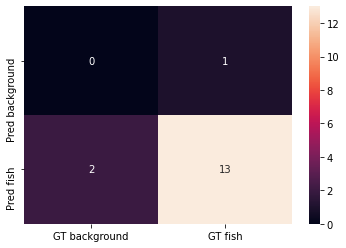

In [172]:
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
y_true = []
y_pred = []

for match in matches:
    y_true.append(1)
    y_pred.append(1)

for match in unmatched_gts:
    y_true.append(1)
    y_pred.append(0)

for match in unmatched_pred:
    y_true.append(0)
    y_pred.append(1)


labels = list(range(len(set(y_true))))

m = confusion_matrix(y_true, y_pred)
df = pd.DataFrame(m, index=["Pred background", "Pred fish"], columns=["GT background", "GT fish"])
sn.heatmap(df, annot=True)